# Removing outliers - outlier trimming

In this notebook, we will remove observations that are beyond certain limits.

We we calculate those limits using:

- The IQR proximity rule
- The normal distribution
- The quantiles

In [1]:
import pandas as pd

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = (10, 8)
sns.set_theme('notebook')

In [3]:
from sklearn import set_config
set_config(transform_output = 'pandas')

In [4]:
# load the California House price data from Scikit-learn
X, y = fetch_california_housing(return_X_y=True, as_frame=True)

# let's separate the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=0,
)

# size
X_train.shape, X_test.shape

((14448, 8), (6192, 8))

In [5]:
X_train.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
1989,1.9750,52.0,2.800000,0.700000,193.0,4.825000,36.73,-119.79
256,2.2604,43.0,3.671480,1.184116,836.0,3.018051,37.77,-122.21
7887,6.2990,17.0,6.478022,1.087912,1387.0,3.810440,33.87,-118.04
4581,1.7199,17.0,2.518000,1.196000,3051.0,3.051000,34.06,-118.28
1993,2.2206,50.0,4.622754,1.161677,606.0,3.628743,36.73,-119.81


In [6]:
def Box_and_Hist_Plots(df, feature):
    """
    Функция для построения диаграммы распределения и коробки с усами
    для оценки нормальности распределения и поиска выбросов

    :param df: Исходный датафрейм
    :param feature: Имя признака для анализа
    :return: Выводит график
    """

    fig, ax = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (0.50, 0.85)})

    sns.boxplot(x=df[feature], ax=ax[0])
    sns.histplot(data=df, x=feature, ax=ax[1])

    ax[0].set(xlabel="")
    ax[0].set_title(f"Box-Plot and Distribution for {feature}")
    plt.tight_layout()
    plt.show()

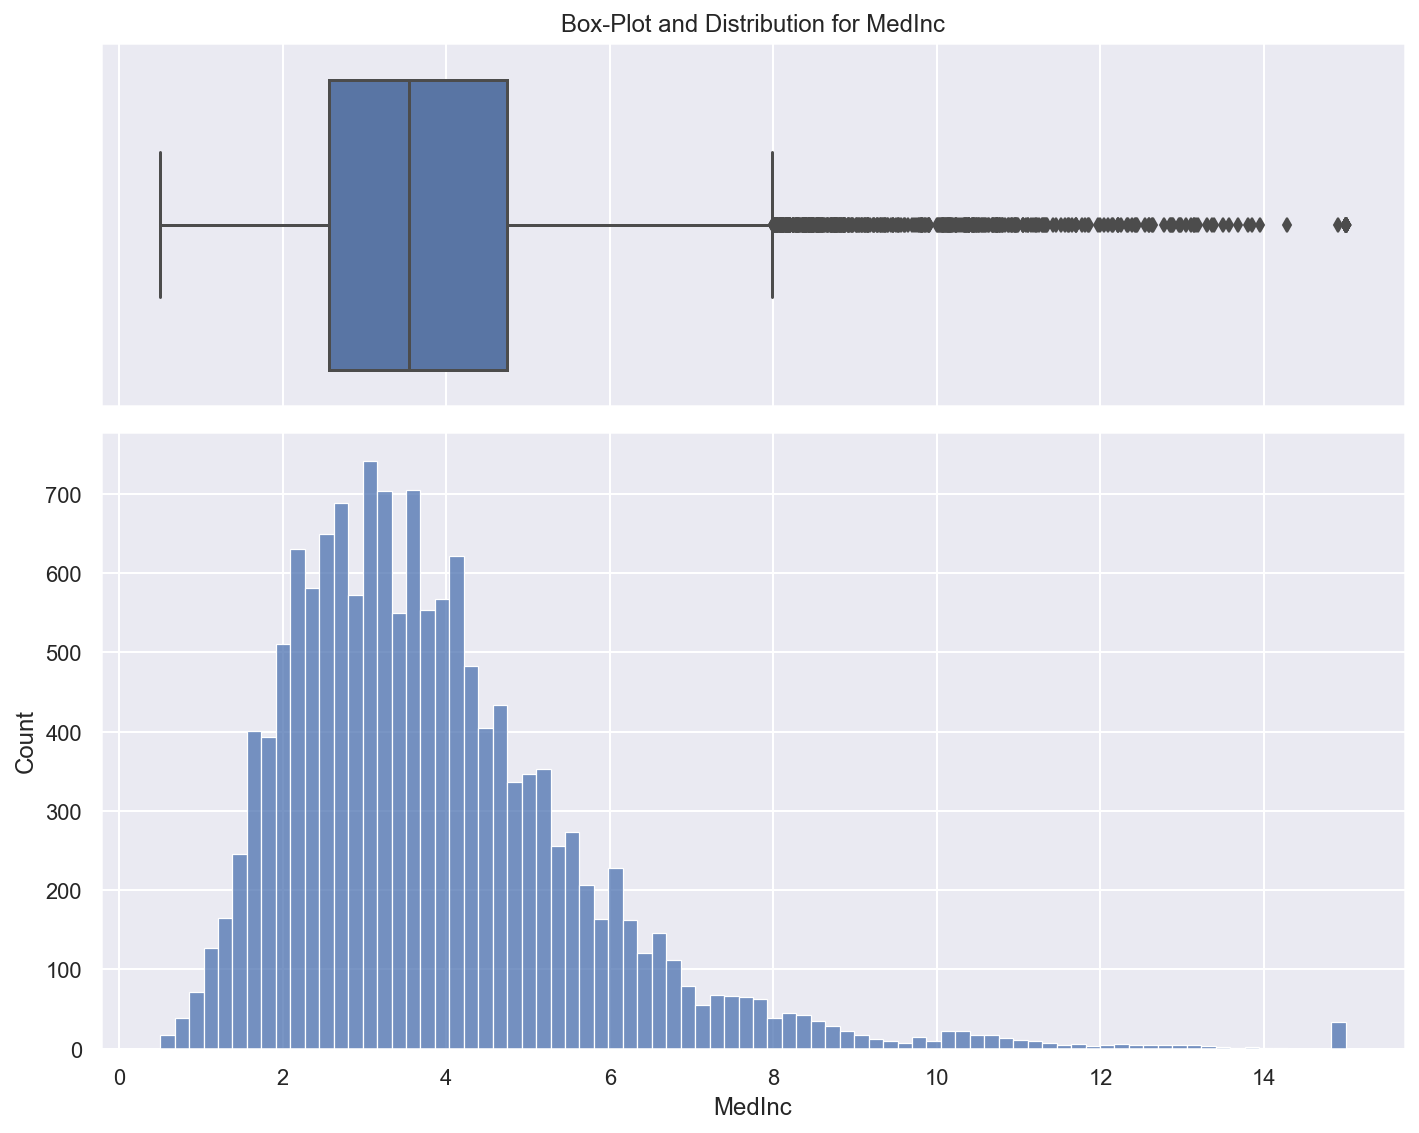

In [7]:
Box_and_Hist_Plots(X_train, "MedInc")

## IQR

In [8]:
def find_limits(df, feature, fold):
    x = df[feature]
    
    quartile_1, quartile_3 = (
        x.quantile(0.25),
        x.quantile(0.75),
    )
    IQR = quartile_3 - quartile_1

    lower_limit = quartile_1 - (IQR * fold)
    upper_limit = quartile_3 + (IQR * fold)

    return lower_limit, upper_limit

In [9]:
# we find the limits
lower_limit, upper_limit = find_limits(X_train, "MedInc", 3)
lower_limit, upper_limit

(-3.925900000000002, 11.232600000000001)

In [10]:
def cut_outliers(train, test, feature, lower_limit, upper_limit):
    tr = train[(train[feature] >= lower_limit) & (train[feature] <= upper_limit)]
    te = test[(test[feature] >= lower_limit) & (test[feature] <= upper_limit)]
    return tr, te

In [11]:
X_train_cut, X_test_cut = cut_outliers(X_train, X_test, 'MedInc', lower_limit, upper_limit)

In [12]:
X_train_cut.shape, X_test_cut.shape

((14348, 8), (6151, 8))

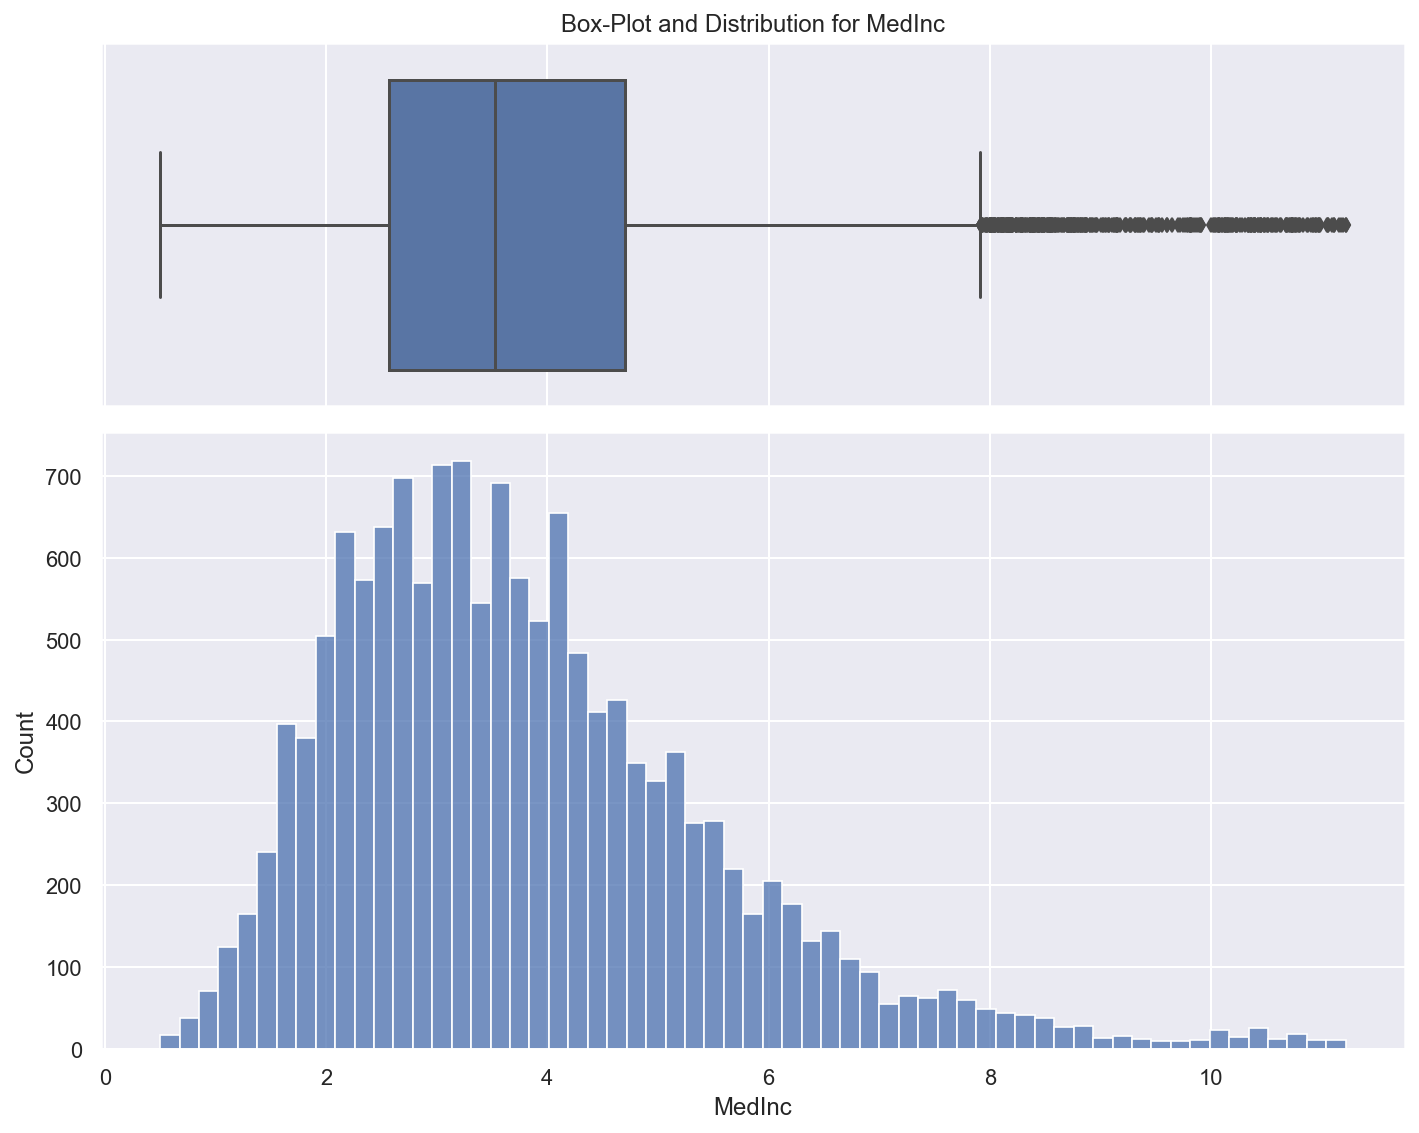

In [13]:
Box_and_Hist_Plots(X_train_cut, "MedInc")

# Sklear implementation

In [14]:
from sklearn.base import BaseEstimator, TransformerMixin

In [15]:
class OutlierRemover(BaseEstimator, TransformerMixin):
    def __init__(self, feature, fold=1.5, find_limits_func=None):
        self.feature = feature
        self.fold = fold
        self.lower_limit = None
        self.upper_limit = None
        self.find_limits_func = find_limits_func

    def fit(self, X, y=None):
        if self.find_limits_func:
            self.lower_limit, self.upper_limit = self.find_limits_func(X, self.feature, self.fold)
        return self

    def transform(self, X, y=None):
        return X[(X[self.feature] >= lower_limit) & (X[self.feature] <= upper_limit)]

In [16]:
# Your find_limits function
def find_limits(df, feature, fold):
    x = df[feature]
    
    quartile_1, quartile_3 = (
        x.quantile(0.25),
        x.quantile(0.75),
    )
    IQR = quartile_3 - quartile_1

    lower_limit = quartile_1 - (IQR * fold)
    upper_limit = quartile_3 + (IQR * fold)

    return lower_limit, upper_limit

In [17]:
# Example usage
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('outlier_remover', OutlierRemover(feature='MedInc', fold=1.5, find_limits_func=find_limits))
])

# Fit the pipeline on the training data
pipeline.fit(X_train)

# Transform both training and test data
X_train_clean = pipeline.transform(X_train)
X_test_clean = pipeline.transform(X_test)

In [18]:
X_train_cut.equals(X_train_clean)

True

In [19]:
X_test_cut.equals(X_test_clean)

True

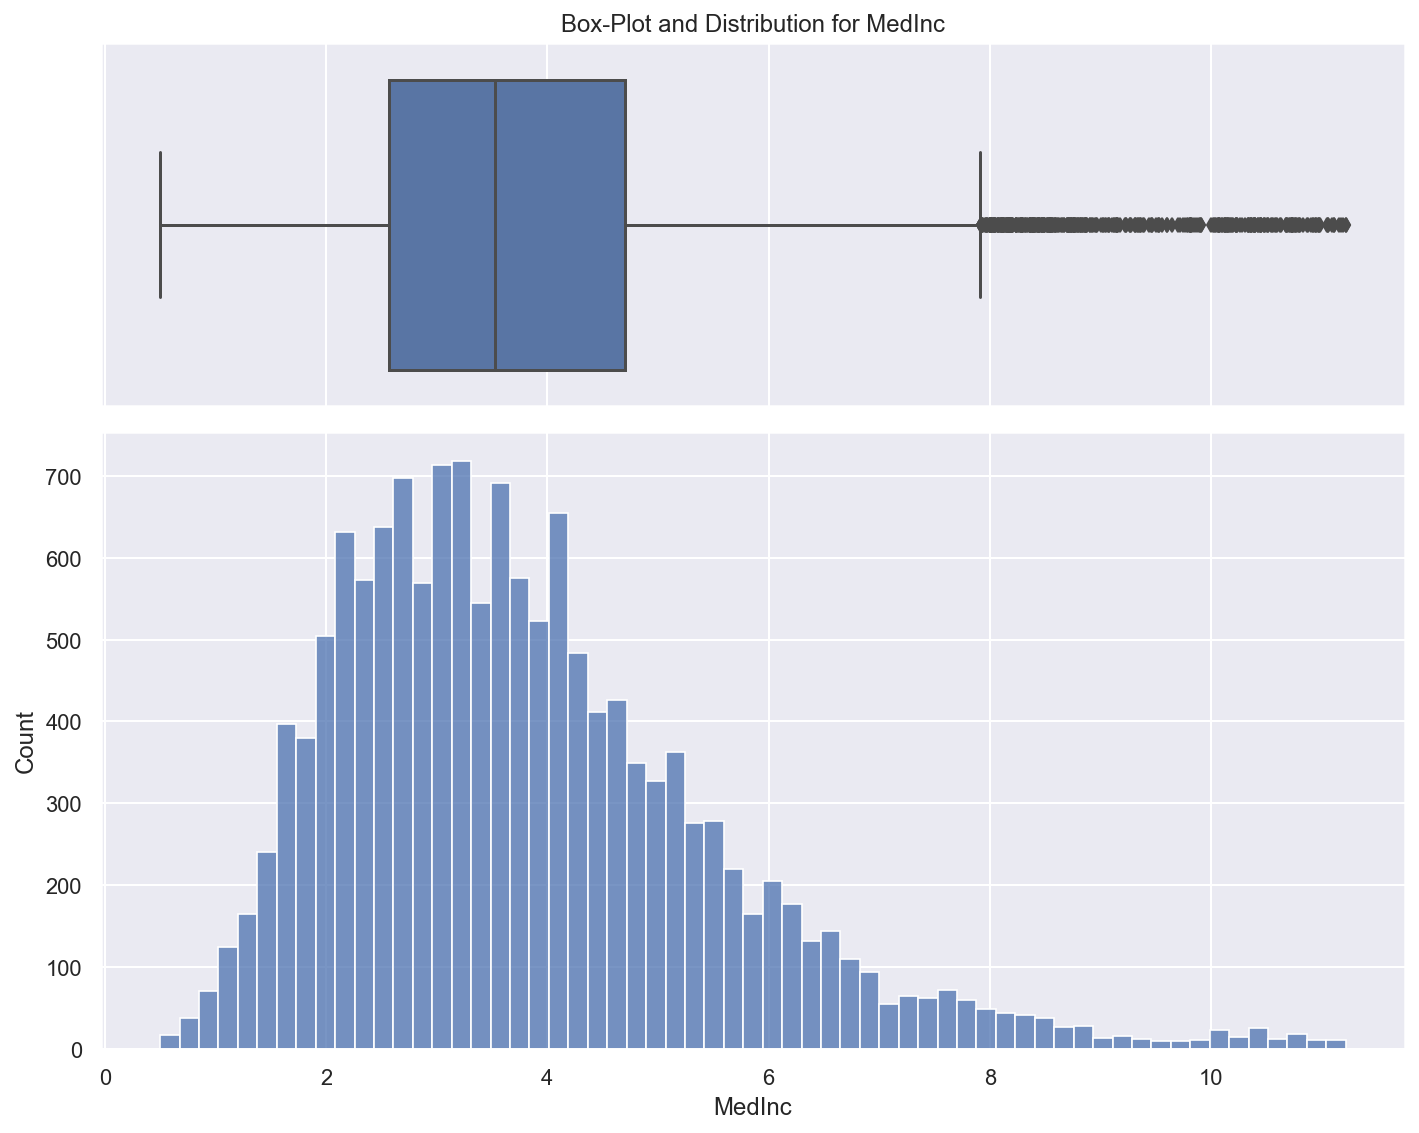

In [20]:
Box_and_Hist_Plots(X_train_clean, "MedInc")